In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install darts
!pip install seaborn
!pip install --upgrade plotly
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from darts import TimeSeries
from darts.models import TCNModel, RNNModel, NBEATSModel, TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, rmse
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 11.7 MB 20.1 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 346 kB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 527 kB 32.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 26.5 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 172 kB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 870 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 62.6 MB 19.6 MB/s eta 0:00:01
     |██████████

In [2]:
# Read data:

missing_values = ["n/a", "na", "NaN", "--", "null"]
df = pd.read_csv('data/CombinedMacroSectorv4.csv', sep=",", na_values = missing_values, index_col=None)
print(df.shape)

(4275, 22)


In [3]:
df.head()

,Date,Oil,Inflation,CPI,Dollar Index,GDP,Unemployment,Recession,Energy,Gold,...,Customer Discretionary,Consumer Staples,Health,Financials,Technology,Telecommunications,Utilities,Real Estate,Cycle,Spy
0,9/29/04,49.53,2.34,189.8,88.099998,3.8,5.4,0,34.720001,NaN,...,31.070000,21.610001,29.350000,23.176279,19.049999,22.680000,25.000000,49.849998,ExpandBeforePeak,129.00000
1,9/30/04,49.56,2.37,189.8,87.360001,3.8,5.4,0,34.930000,NaN,...,31.200001,21.660000,28.790001,23.119415,19.120001,22.620001,25.049999,50.250000,ExpandBeforePeak,130.09375
2,10/1/04,50.16,2.38,190.8,87.629997,4.1,5.5,0,35.430000,NaN,...,31.590000,21.879999,29.059999,23.509342,19.600000,22.990000,25.250000,51.180000,ExpandBeforePeak,129.43750
3,10/4/04,49.85,2.33,190.8,88.379997,4.1,5.5,0,35.389999,NaN,...,31.889999,21.830000,29.190001,23.541836,19.760000,23.309999,25.350000,51.400002,ExpandBeforePeak,127.81250
4,10/5/04,51.08,2.34,190.8,88.169998,4.1,5.5,0,35.770000,NaN,...,31.850000,21.830000,29.100000,23.411860,19.900000,23.400000,25.459999,51.389999,ExpandBeforePeak,130.12500


In [4]:
df['time'] = pd.to_datetime(df['Date'],utc=True)
df['time']= df.time.dt.tz_localize(None)
#df['Time'] = normalize(df)
#df['Class'] = df['Recession']
#std_normalize(["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
#"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
#"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"], df)
df.drop(['Date'], axis=1, inplace=True)
#df.drop(['Cycle'], axis=1, inplace=True)
#df.drop(['Gold'], axis=1, inplace=True)

#ts = scaler.fit_transform(
#    ts
#)  # scale the whole time series not caring about train/val split...

In [5]:
daily_cov = pd.read_csv('data/news_sentiment_data.csv', sep=",", na_values = missing_values, index_col=None)
print(daily_cov.shape)

(5985, 2)


In [6]:
daily_cov.head()

,date,sentiment
0,9/29/04,0.167411
1,9/30/04,0.173788
2,10/1/04,0.167044
3,10/2/04,0.161869
4,10/3/04,0.165404


In [7]:
daily_cov['time'] = pd.to_datetime(daily_cov['date'],utc=True)
daily_cov['time']= daily_cov.time.dt.tz_localize(None)
daily_cov.drop(['date'], axis=1, inplace=True)
#daily_cov = daily_cov.time.isin(df.time)
daily_cov = daily_cov[daily_cov.time.isin(df.time)]
print(daily_cov.shape)

(4275, 2)


<AxesSubplot:>

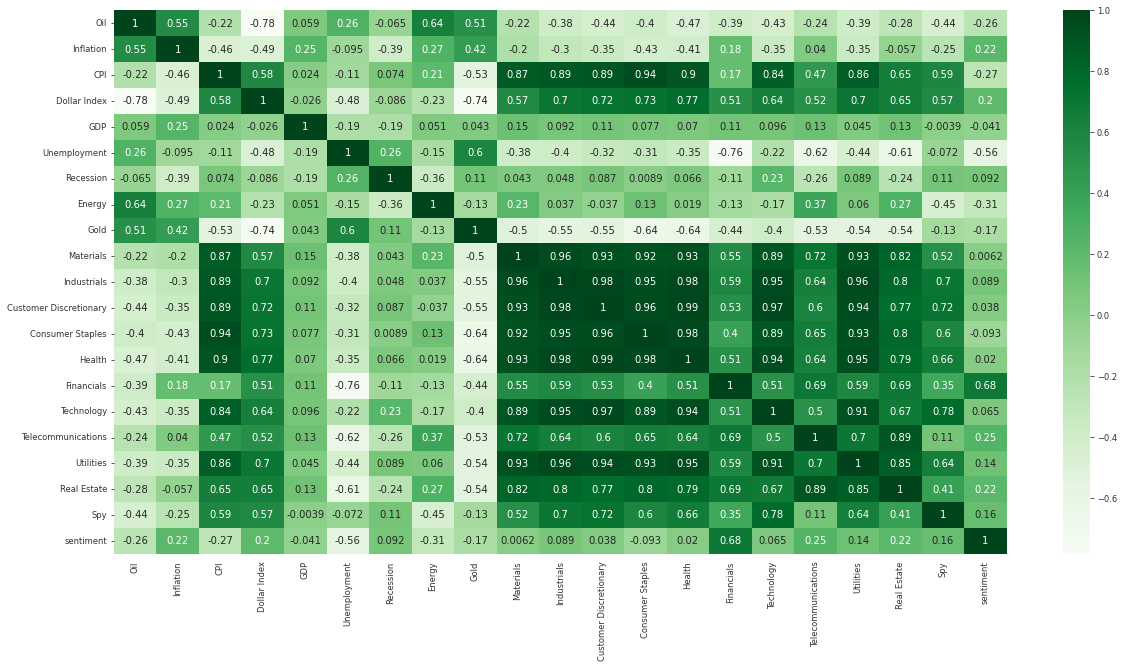

In [8]:
result = pd.concat([df, daily_cov], axis=1).corr()
sns.heatmap(result, cmap="Greens",annot=True)

In [9]:
series_cov = TimeSeries.from_dataframe(daily_cov, 'time', ["sentiment"])

In [10]:
scaler_cov = Scaler(MinMaxScaler(feature_range=(-1, 1)))
series_cov_transformed = scaler_cov.fit_transform(
    series_cov
)

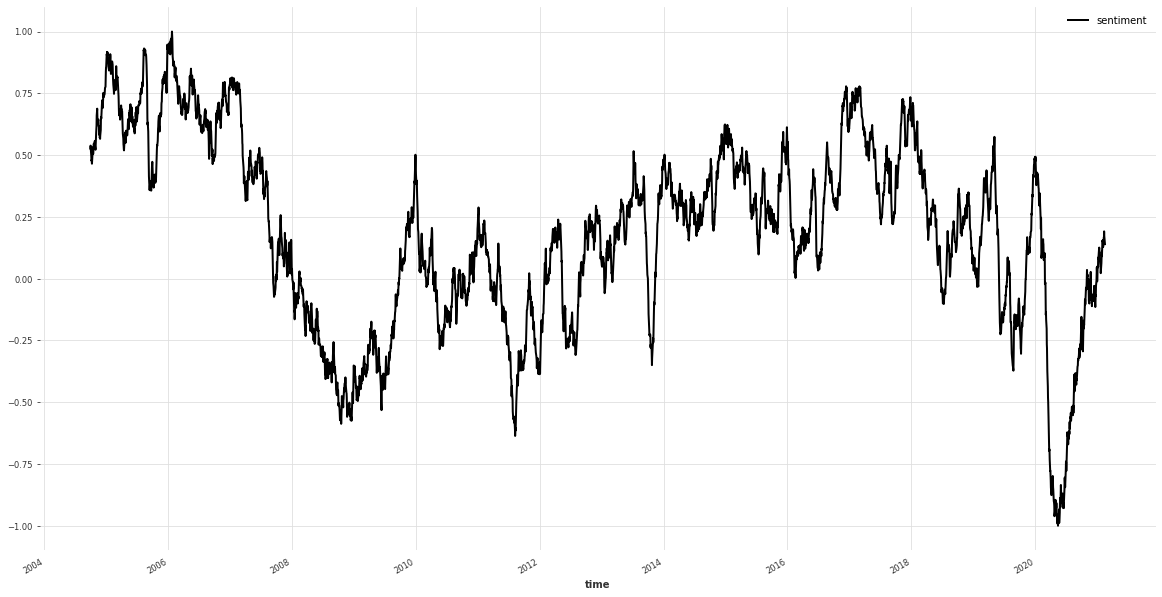

In [11]:
train_cov, val_cov =  series_cov_transformed.split_after(pd.Timestamp('20170901'))
series_cov_transformed.plot()

In [12]:
columns = ["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"]

series = TimeSeries.from_dataframe(df, 'time', ['Oil', "CPI", "Dollar Index", "Spy"])

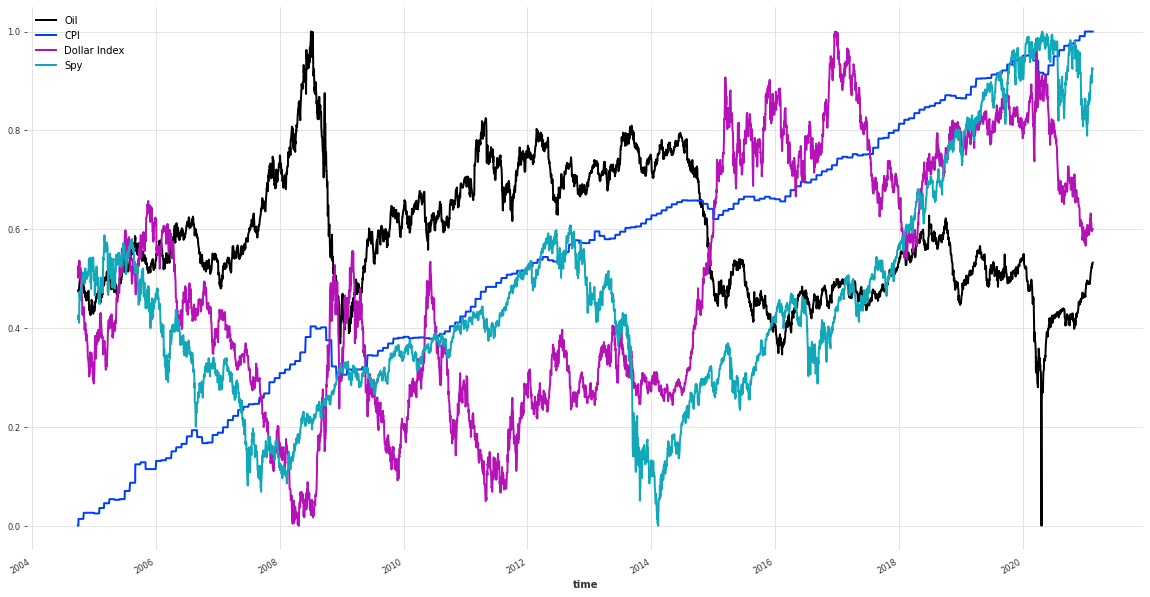

In [13]:
scaler = Scaler()
series_transformed = scaler.fit_transform(
    series
)  #scale the whole time series not caring about train/val split..

train, val =  series_transformed.split_after(pd.Timestamp('20170901'))
series_transformed.plot()

In [14]:
seasonality = check_seasonality(series_transformed["Spy"], max_lag=series_transformed.n_timesteps)
print(seasonality)

(True, 1943)


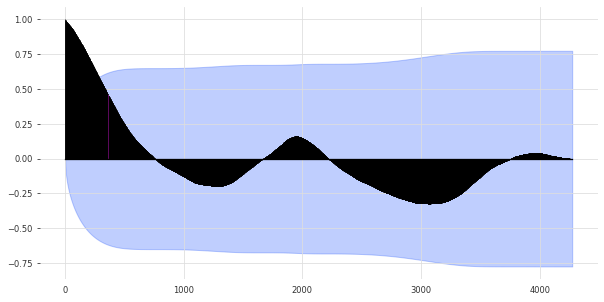

In [15]:
plot_acf(series_transformed["Spy"], 365, max_lag=series_transformed.n_timesteps-1)

In [16]:
stationary = stationarity_tests(series_transformed["Spy"])
print(stationary)

False


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [17]:
def tft_model(hiddensize, layers, attention, train_series, val_series, past_covariates_train=None, past_covariates_val=None, future_covariates_train=None, future_covariates_val=None):

    model = TFTModel(
        input_chunk_length=365,
        output_chunk_length=7,
        n_epochs=100,
        hidden_size=hiddensize,
        lstm_layers=layers,
        num_attention_heads=attention,
        nr_epochs_val_period=20,
        dropout=0.2,
        batch_size=16,
        add_relative_index=False,
        add_encoders={'cyclic': {'future': ['month']}},
        pl_trainer_kwargs={"accelerator": "gpu", "gpus": -1, "auto_select_gpus": True, "enable_progress_bar": False},
        optimizer_kwargs={"lr": 1e-3},
        # loss_fn=MSELoss(),
    )

    model.fit(
        series=train_series,
        val_series=val_series,
        past_covariates=past_covariates_train,
        val_past_covariates=past_covariates_val,
        future_covariates=future_covariates_train,
        val_future_covariates=future_covariates_val,
        #verbose=True,
    )

    return model

In [18]:
def eval_model(model, series, past_covariates=None, future_covariates=None):
    backtest = model.historical_forecasts(
        series=series,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.7,
        forecast_horizon=7,
        stride=10,
        retrain=False,
        #verbose=True,
    )
    series.plot(label="actual")
    backtest.plot(label="backtest (H=7 day)")
    r2_score_value = r2_score(series, backtest)
    plt.title('R2:' + str(r2_score_value) + ' Backtest RMSE = {}'.format(rmse(series, backtest)))
    plt.legend()

In [19]:
model = tft_model(32, 1, 4, train, val) #was 5
#model.save_model('tft.pth.tar')

[2022-03-07 18:20:22,529] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 18:20:22,529] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 18:20:22,549] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 18:20:22,549] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:18<00:03,  9.90it/s, loss=0.103]
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:18<00:03,  9.93it/s, loss=0.0818]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:19<00:03,  9.79it/s, loss=0.0715]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:19<00:03,  9.88it/s, loss=0.0708]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:19<00:03,  9.87it/s, loss=0.0611]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:20<00:00, 11.03it/s, loss=0.0611]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


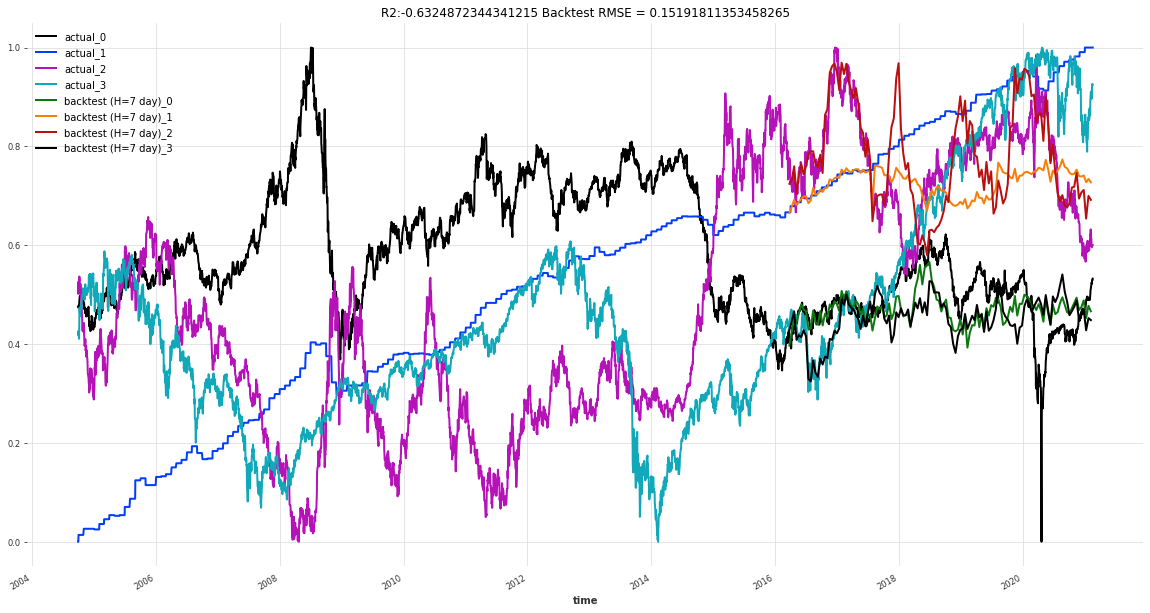

In [20]:
eval_model(model, series_transformed)

In [21]:
model = tft_model(32, 1, 4, train, val, train_cov, val_cov)

[2022-03-07 18:52:45,864] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 18:52:45,864] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 18:52:45,886] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 18:52:45,886] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:21<00:03,  8.90it/s, loss=0.1]   
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:20<00:03,  9.00it/s, loss=0.0813]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:20<00:03,  8.95it/s, loss=0.0686]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:20<00:03,  9.01it/s, loss=0.0603]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:20<00:03,  8.95it/s, loss=0.0574]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:22<00:00, 10.01it/s, loss=0.0574]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


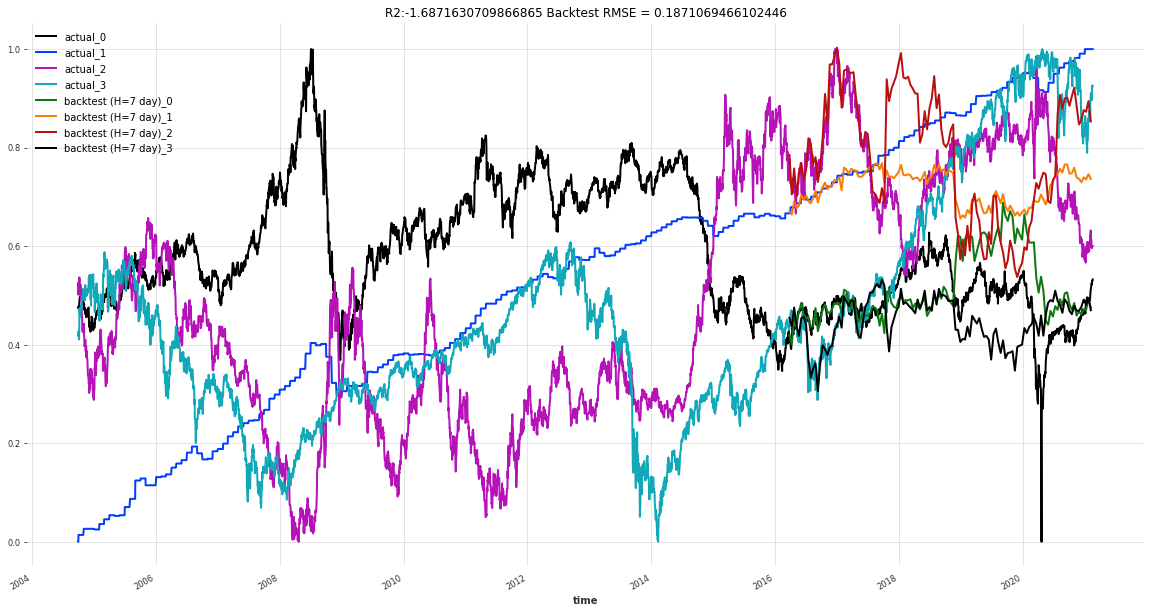

In [22]:
eval_model(model, series_transformed, series_cov_transformed)

In [23]:
model = tft_model(16, 1, 4, train, val)

[2022-03-07 19:28:16,405] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 19:28:16,405] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 19:28:16,423] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 19:28:16,423] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:17<00:03, 10.59it/s, loss=0.142]
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:17<00:03, 10.62it/s, loss=0.113]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:17<00:03, 10.60it/s, loss=0.102] 
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:17<00:03, 10.63it/s, loss=0.091] 
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:17<00:03, 10.59it/s, loss=0.0855]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:18<00:00, 11.83it/s, loss=0.0855]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


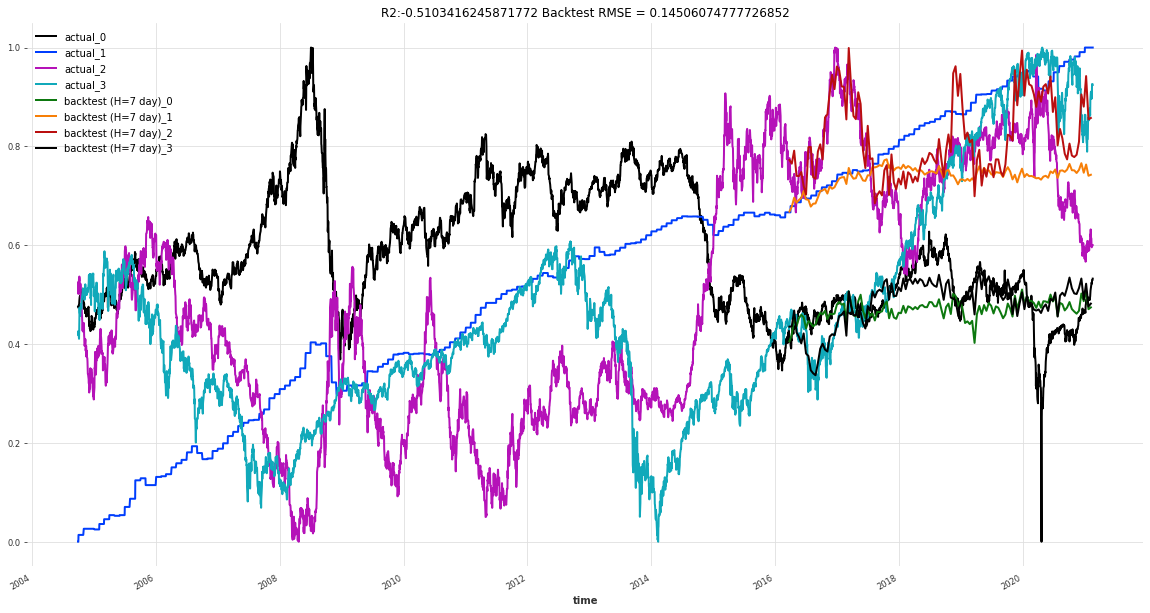

In [24]:
eval_model(model, series_transformed)

In [25]:
model = tft_model(16, 1, 4, train, val, train_cov, val_cov)

[2022-03-07 19:58:15,768] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 19:58:15,768] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 19:58:15,787] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 19:58:15,787] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:19<00:03,  9.61it/s, loss=0.131]
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:19<00:03,  9.63it/s, loss=0.111]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:19<00:03,  9.62it/s, loss=0.0943]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:19<00:03,  9.63it/s, loss=0.0842]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:19<00:03,  9.60it/s, loss=0.0809]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:20<00:00, 10.73it/s, loss=0.0809]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


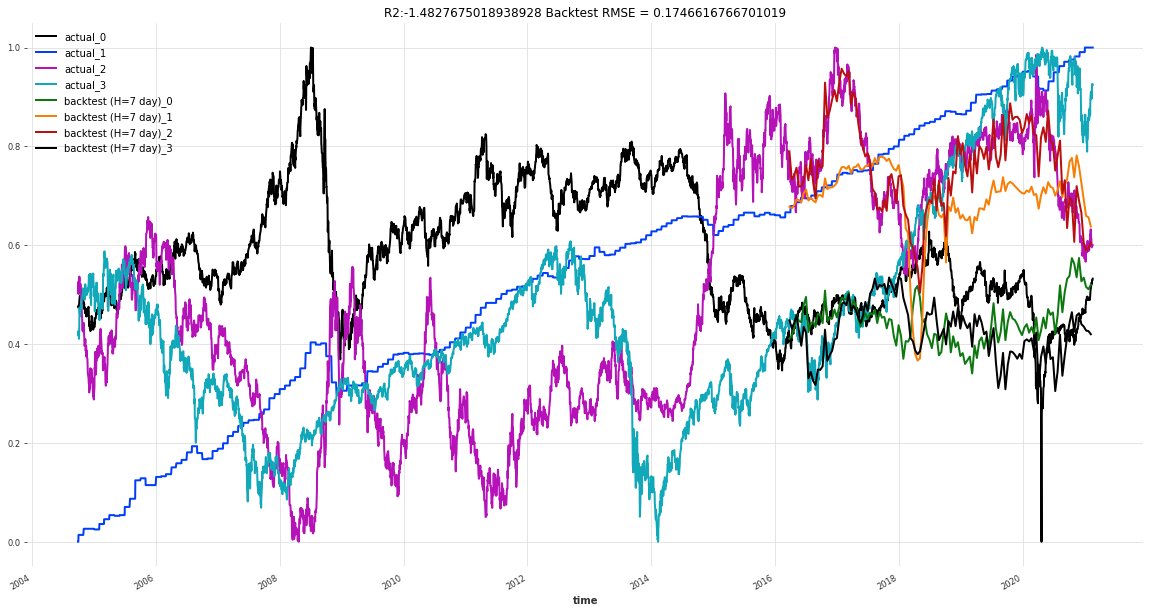

In [26]:
eval_model(model, series_transformed, series_cov_transformed)

In [27]:
model = tft_model(24, 1, 4, train, val)

[2022-03-07 20:31:19,712] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 20:31:19,712] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 20:31:19,731] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 20:31:19,731] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:18<00:03, 10.24it/s, loss=0.12] 
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:18<00:03, 10.26it/s, loss=0.0903]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:18<00:03, 10.28it/s, loss=0.0803]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:18<00:03, 10.22it/s, loss=0.0749]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:18<00:03, 10.27it/s, loss=0.0692]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:19<00:00, 11.46it/s, loss=0.0692]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


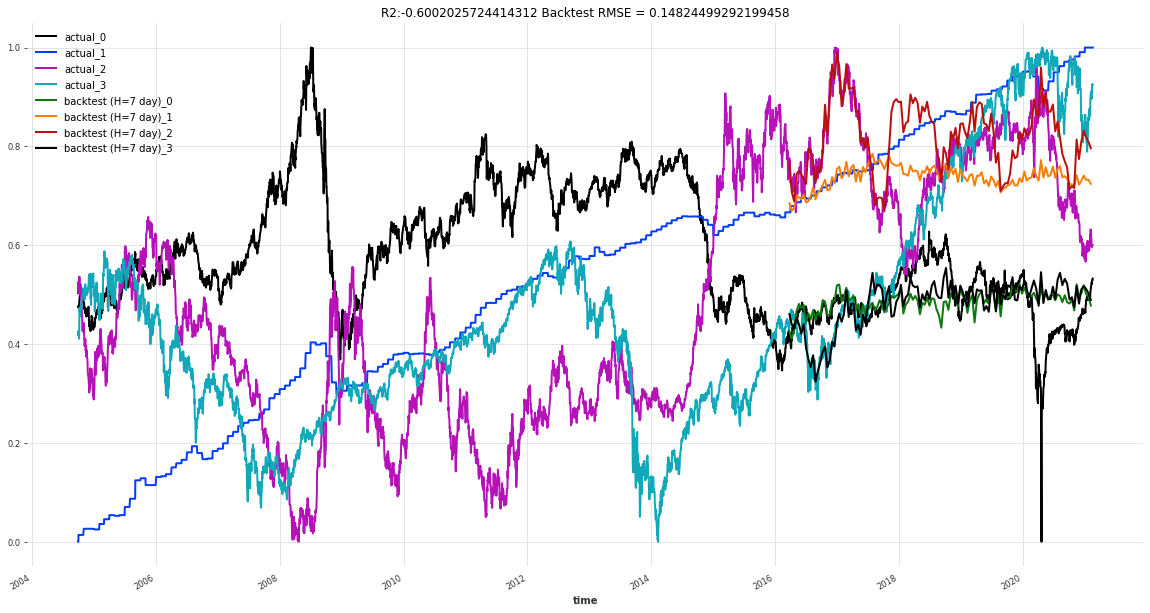

In [28]:
eval_model(model, series_transformed)

In [29]:
model = tft_model(24, 1, 4, train, val, train_cov, val_cov)

[2022-03-07 21:02:22,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 21:02:22,876] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 21:02:22,897] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 21:02:22,897] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:20<00:03,  9.28it/s, loss=0.105]
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:20<00:03,  9.34it/s, loss=0.0872]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:20<00:03,  9.33it/s, loss=0.0782]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:20<00:03,  9.32it/s, loss=0.0706]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:20<00:03,  9.34it/s, loss=0.0661]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:21<00:00, 10.43it/s, loss=0.0661]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


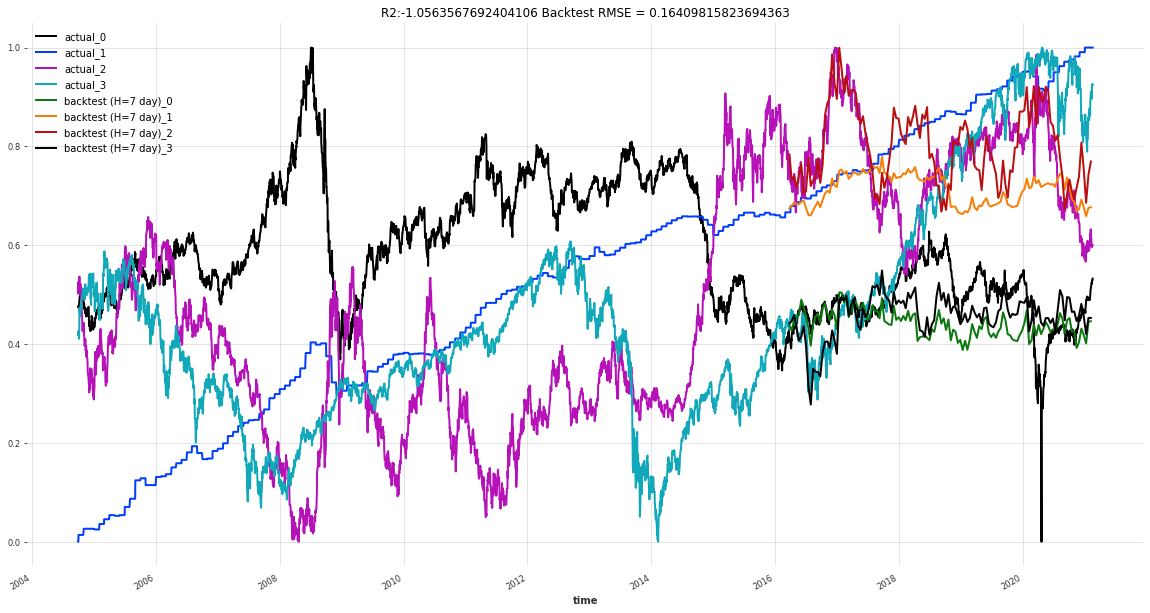

In [30]:
eval_model(model, series_transformed, series_cov_transformed)

In [31]:
model = tft_model(32, 2, 4, train, val, train_cov, val_cov)

[2022-03-07 21:36:31,167] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 21:36:31,167] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-03-07 21:36:31,189] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-07 21:36:31,189] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork 

Epoch 19:  85%|████████▍ | 188/222 [00:24<00:04,  7.80it/s, loss=0.115]
Validating: 0it [00:00, ?it/s]
Epoch 39:  85%|████████▍ | 188/222 [00:24<00:04,  7.82it/s, loss=0.0863]
Validating: 0it [00:00, ?it/s]
Epoch 59:  85%|████████▍ | 188/222 [00:23<00:04,  7.85it/s, loss=0.0729]
Validating: 0it [00:00, ?it/s]
Epoch 79:  85%|████████▍ | 188/222 [00:24<00:04,  7.82it/s, loss=0.0665]
Validating: 0it [00:00, ?it/s]
Epoch 99:  85%|████████▍ | 188/222 [00:24<00:04,  7.83it/s, loss=0.06]  
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 222/222 [00:25<00:00,  8.77it/s, loss=0.06]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 188it [00:00, ?it/s]


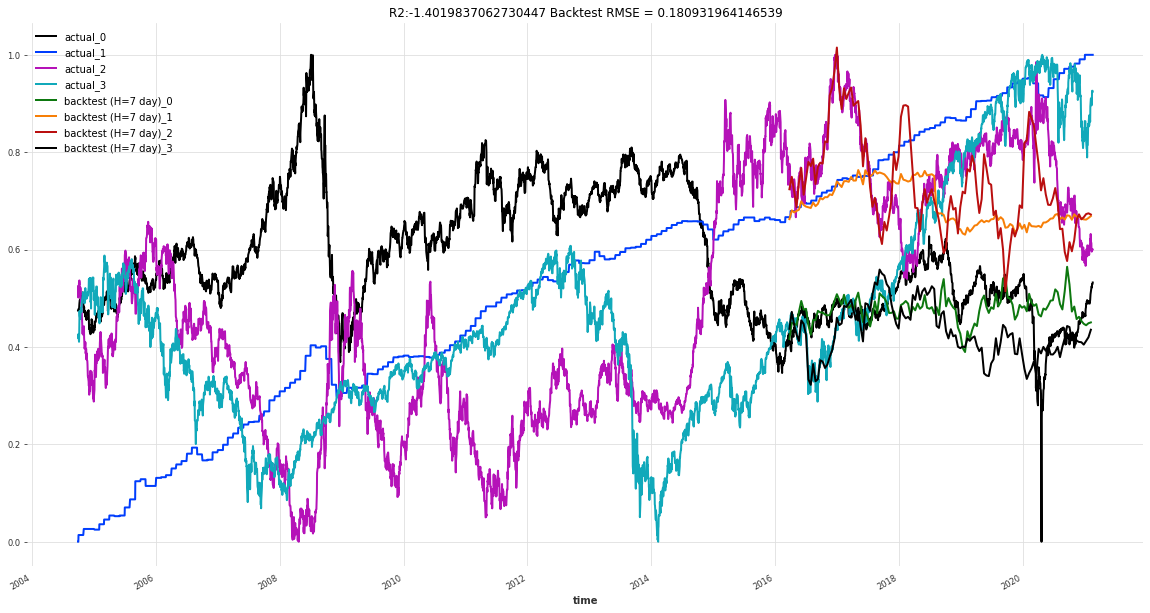

In [32]:
eval_model(model, series_transformed, series_cov_transformed)